In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [2]:
torch.manual_seed(42)

In [3]:
df = pd.read_csv(r"D:\Datasets\fashion_mnist\fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


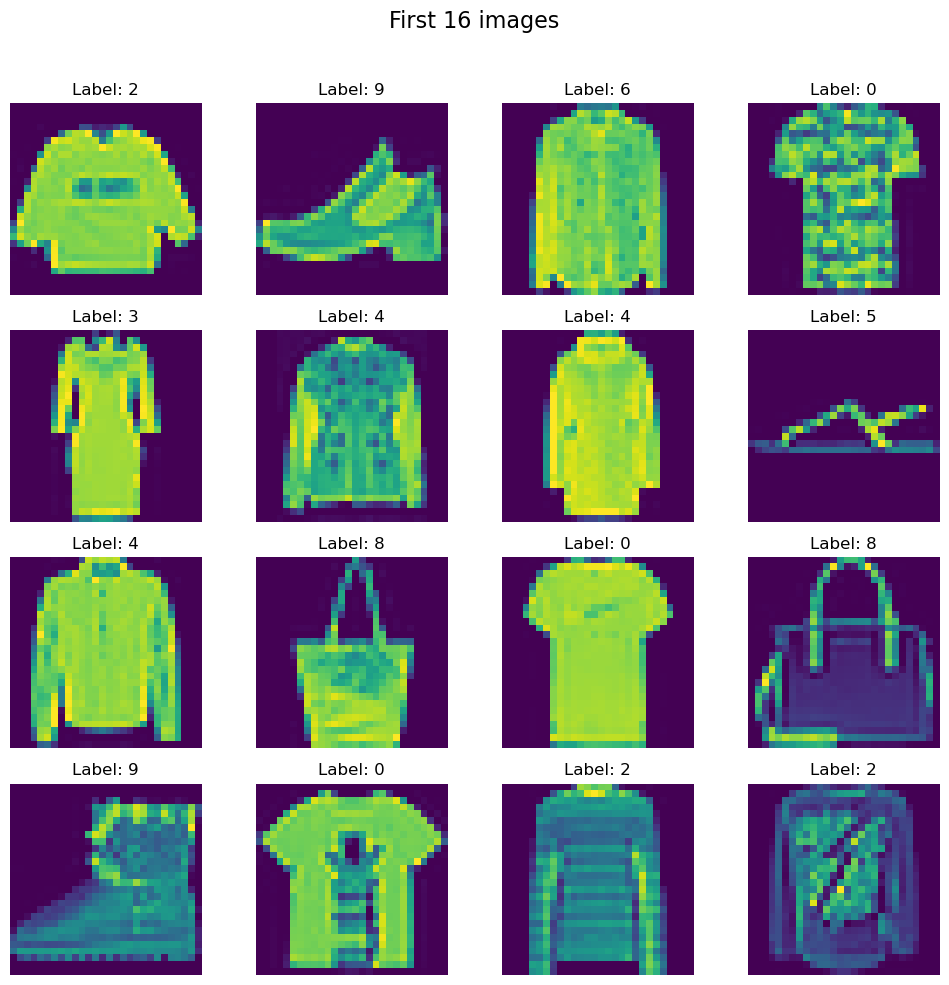

In [4]:
#Creating 4x4 grid of images
fig, axes = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("First 16 images", fontsize=16)

#Plot first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Scaling the features
X_train = X_train/255
X_test = X_test/255

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 3070 Laptop GPU


In [9]:
#Creating a custom dataset class

class customDataset(Dataset):    

    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [10]:
#Creating a train and test datasets
train_dataset = customDataset(X_train, y_train)
test_dataset = customDataset(X_test, y_test)

In [11]:
#Creating train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [12]:
#Creating an Artificial Neural Network

class artificialNN(nn.Module):

    def __init__(self, num_features):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        return self.model(X)

In [13]:
epochs = 300
learning_rate = 0.1

In [14]:
# Instantiating the model
model = artificialNN(X_train.shape[1])
model = model.to(device=device)
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [15]:
# training loop

for epoch in range(epochs):

    Epoch_loss = 0
    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device=device), batch_labels.to(device=device)
       
        # Forward Pass
        outputs = model(batch_features)

        # Calculate Loss
        loss = criterion(outputs, batch_labels)

        # Backward Pass
        optim.zero_grad()
        loss.backward()

        # Update the weights
        optim.step()
        Epoch_loss += loss.item()

    avg_epoch_loss = Epoch_loss/len(batch_features)
    # print(f"Loss after Epoch {epoch+1}: {avg_epoch_loss}")

In [16]:
# Evaluating the model
model.eval()

artificialNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [17]:
# Evaluation Code on test data

total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:

        batch_features, batch_labels = batch_features.to(device=device), batch_labels.to(device=device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        
        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

    print(f"Test accuracy: {correct/total}")

Test accuracy: 0.8895833333333333


In [18]:
# Evaluation Code on test data

total_train = 0
correct_train = 0

with torch.no_grad():

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device=device), batch_labels.to(device=device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        
        total_train += batch_labels.shape[0]
        correct_train += (predicted == batch_labels).sum().item()

    print(f"Train accuracy: {correct_train/total_train}")

Train accuracy: 0.9656875
